# Libraries

In [5]:
import psutil
psutil.virtual_memory() 

svmem(total=540408909824, available=419650011136, percent=22.3, used=117073281024, free=421205884928, active=961441792, inactive=109381664768, buffers=5439488, cached=2124304384, shared=740438016, slab=1182363648)

In [6]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

In [7]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [ ]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [ ]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [ ]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [ ]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [ ]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [ ]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [5]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [6]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

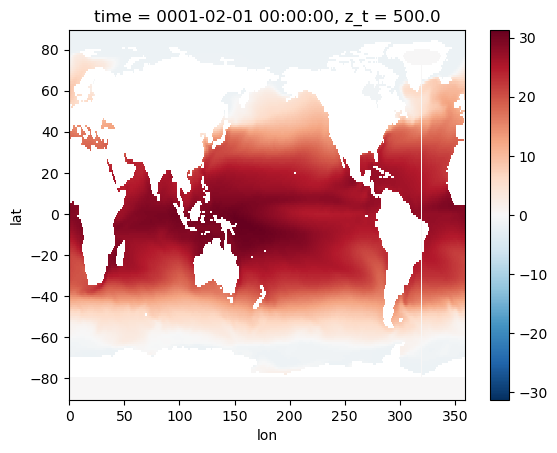

In [7]:
ds_tos.isel(time=0).plot()

## Subset data

In [8]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [9]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

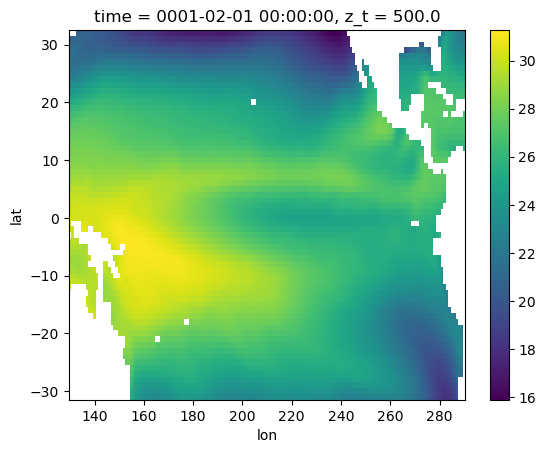

In [10]:
S_tos.isel(time=0).plot()

In [11]:
del(ds_tos, ds_ssh)

In [12]:
import psutil
psutil.virtual_memory() 

svmem(total=540408909824, available=498351804416, percent=7.8, used=39251271680, free=500114878464, active=433221632, inactive=31795372032, buffers=3805184, cached=1038954496, shared=69345280, slab=932626432)

## Create matrices, de-trending data and anomalies

In [13]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [14]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
del(S_tos,S_ssh)

In [16]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [17]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [18]:
del(X_ssh)

# 100 years

### Tools for the plots

In [5]:
import nc_time_axis

In [6]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [7]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

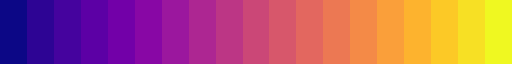

In [8]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [9]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [10]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_200=[0,1,2,3,4,5,6,7,8,9]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [25]:
mean_av=np.zeros((24,10))   #leads, number of operators, number of periods
mean_ind=np.zeros((24,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,10))

In [26]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [27]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

### Upload data

In [28]:
tot_for=np.zeros((20, 19, 1845, 24, 1176))

In [29]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

In [30]:
tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [31]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [32]:
del(tot_for)

In [33]:
tot_for_union.shape

(19, 1845, 24, 24000)

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[m*2,:,:,200*12*m:200*12+200*12*m].copy()
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=tot_for_union1
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(1):  
            phix_geo_array=udat_sst @ tot_for_union1[0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=mean_av[lead,m]
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(1):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


In [ ]:
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_CORR_GAUSALL_100', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_100', mean_ind, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_RMSE_GAUSALL_100', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_100', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [ ]:
mean_av=np.zeros((24,10))   #leads, number of operators, number of periods
mean_ind=np.zeros((24,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

### Upload data

In [ ]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [ ]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/30EOFs_forecast_p{n}.npy')

In [ ]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
del(tot_for)

In [ ]:
tot_for_union.shape

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[m*2,:,:,200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=tot_for_union1
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(1):  
            phix_geo_array=udat_sst @ tot_for_union1[0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=mean_av[lead,m]
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''     #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(1):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


In [ ]:
#Period 1
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_CORR_GAUSS30_100', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100', mean_ind, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_RMSE_GAUSS30_100', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_100', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [ ]:
mean_av=np.zeros((24,10))   #leads, number of operators, number of periods
mean_ind=np.zeros((24,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

### Upload data

In [ ]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [ ]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/Poly_forecast_p{n}.npy')

In [ ]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
del(tot_for)

In [ ]:
tot_for_union.shape

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[m*2,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=tot_for_union1
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(1):  
            phix_geo_array=udat_sst @ tot_for_union1[0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=mean_av[lead,m]
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
'''     #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(1):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()'''


In [ ]:
#Period 1
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_CORR_POLY_100', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_CORR_POLY_100', mean_ind, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_RMSE_POLY_100', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_RMSE_POLY_100', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [ ]:
Poly_mean=np.load('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Poly_ind=np.load('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')

Gauss30_mean=np.load('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
Gauss30_ind=np.load('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')

GaussALL_mean=np.load('Other skill metrics/200 years testing/200y_ENSEMBLE_MEAN_CORR_GAUSALL_100.npy')
GaussALL_ind=np.load('Other skill metrics/200 years testing/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_100.npy')


In [ ]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0,1.0])
ax.set_title('',loc='left')

ax.plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Poly 30 Ens')
ax.plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
ax.plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')

plt.gca().set_prop_cycle(None)

ax.plot(xval, np.mean(Poly_ind, axis=1), lw=1.5, label='Poly 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(Gauss30_ind, axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(GaussALL_ind, axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')


ax.plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')





bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# 50 years

### Tools for the plots

In [ ]:
import nc_time_axis

In [ ]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [ ]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

In [ ]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [ ]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [ ]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_200=[0,1,2,3,4,5,6,7,8,9]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [ ]:
mean_av=np.zeros((24,10))
mean_ind=np.zeros((24,4,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,4,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

In [ ]:
tot_for_union=np.empty((4, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods_200:
        tot_for_union[:,:,m, m + n*2400 : m + n*2400 +2376]=np.load(f'200 years testing/200 years testing-Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(4):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(4):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()


In [ ]:
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_50', mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50', mean_ind, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_RMSE_GAUSALL_50', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_50', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [ ]:
mean_av=np.zeros((24,10))
mean_ind=np.zeros((24,4,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,4,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

In [ ]:
tot_for_union=np.empty((4, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods_200:
        tot_for_union[:,:,m, m + n*2400 : m + n*2400 +2376]=np.load(f'200 years testing/200 years testing-Forecasts 50/30EOFs_forecast_p{n}.npy')[:,0:20,m,:]

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(4):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(4):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()


In [ ]:
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_50', mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50', mean_ind, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_RMSE_GAUSS30_50', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_50', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [ ]:
mean_av=np.zeros((24,10))
mean_ind=np.zeros((24,4,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,4,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

In [ ]:
tot_for_union=np.empty((4, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods_200:
        tot_for_union[:,:,m, m + n*2400 : m + n*2400 +2376]=np.load(f'200 years testing/200 years testing-Forecasts 50/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(4):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(4):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()


In [ ]:
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_50', mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_50', mean_ind, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_RMSE_POLY_50', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_RMSE_POLY_50', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [ ]:
Poly_mean=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Poly_ind=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')

Gauss30_mean=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
Gauss30_ind=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')

GaussALL_mean=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_50.npy')
GaussALL_ind=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')


In [ ]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [ ]:
np.mean(Poly_ind, axis=1).shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0,1.0])
ax.set_title('',loc='left')

ax.plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Poly 30 Ens')
ax.plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
ax.plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')

plt.gca().set_prop_cycle(None)

ax.plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Poly 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')


ax.plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')


bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# 25 years

### Tools for the plots

In [ ]:
import nc_time_axis

In [ ]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [ ]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

In [ ]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [ ]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [ ]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods_200=[0,1,2,3,4,5,6,7,8,9]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

## ALL GAUSS

In [ ]:
mean_av=np.zeros((24,10))
mean_ind=np.zeros((24,8,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,8,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

In [ ]:
tot_for_union=np.empty((8, 845, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods_200:
        tot_for_union[:,:,m, m + n*2400 : m + n*2400 +2376]=np.load(f'200 years testing/200 years testing-Forecasts 25/ALLEOFs_forecast_p{n}.npy')[:,0:845,m,:]

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(8):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(8):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:845,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()


In [ ]:
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_25', mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25', mean_ind, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_RMSE_GAUSALL_25', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_RMSE_GAUSALL_25', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 GAUSS

In [ ]:
mean_av=np.zeros((24,10))
mean_ind=np.zeros((24,8,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,8,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

In [ ]:
tot_for_union=np.empty((8, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods_200:
        tot_for_union[:,:,m, m + n*2400 : m + n*2400 +2376]=np.load(f'200 years testing/200 years testing-Forecasts 25/30EOFs_forecast_p{n}.npy')[:,0:20,m,:]

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(8):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(8):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()


In [ ]:
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_25', mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25', mean_ind, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_RMSE_GAUSS30_25', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_RMSE_GAUSS30_25', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## 30 POLY

In [ ]:
mean_av=np.zeros((24,10))
mean_ind=np.zeros((24,8,10))

RMSE_mean_av=np.zeros((24,10))
RMSE_mean_ind=np.zeros((24,8,10))

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [ ]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

In [ ]:
tot_for_union=np.empty((8, 20, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods_200:
        tot_for_union[:,:,m, m + n*2400 : m + n*2400 +2376]=np.load(f'200 years testing/200 years testing-Forecasts 25/POLY_forecast_p{n}.npy')[:,0:20,m,:]

In [ ]:
for m in periods_200:

    Xindex1=Xindex.isel(time=slice(0+200*12*m,200*12+200*12*m))
    X_tos1=X_tos.A[:,0+200*12*m:200*12+200*12*m]
    
    tot_for_union1=tot_for_union[:,:,:,0+200*12*m:200*12+200*12*m]
    print('Period ', m, '  forecast: ',m*2)
    
    for n in lead_times:
    
        lead=n
    
        # Compute average forecast
        av_for=np.nanmean(tot_for_union1, axis=0)
        av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
        av_for_geo = xr.full_like(X_tos1[:,:],0)
        av_for_geo.data=av_for_geo_array.real
        Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        mean_av[lead,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])[0,1]
        RMSE_mean_av[lead,m]=1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Avindex))],Avindex[np.invert(np.isnan(Avindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Avindex))])
        print("Lead ", n, " ensemble mean correlation ",mean_av[lead,m])
    
        #Average correlation between individual forecast and observations
        for i in range(8):  
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

            mean_ind[lead,i,m]=np.corrcoef(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])[0,1]
            RMSE_mean_ind[lead,i,m]= 1-np.sqrt(np.square(np.subtract(Xindex1[np.invert(np.isnan(Phiindex))],Phiindex[np.invert(np.isnan(Phiindex))])).mean()) / np.std(Xindex1[np.invert(np.isnan(Phiindex))])
            
        av_corr=np.mean(mean_ind[lead,:,m], axis=0)
        print("Lead ", n, " ensemble member correlation ",av_corr)
        
        
        #Plot
        import nc_time_axis
    
        fig, ax = plt.subplots(1, 1, figsize=(16,3.5),squeeze=False)
    
        Xindex1.plot(label='Untruncated Obs',lw=1.2,color='gray')
    
        for i in range(8):  
            #Expand forecast to geographical domain
            phix_geo_array=udat_sst @ tot_for_union1[i,0:20,lead,:]  
            phix_geo = xr.full_like(X_tos1[:,:],0)
            phix_geo.data=phix_geo_array.real
    
            Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
            Phiindex.plot(lw=0.5, color='red', alpha=0.4)
    
        Avindex.plot(label='Average forecast',lw=0.8,color='blue')

        plt.axhline(0,color='black',lw=0.5)
        plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
        plt.title(f'Gaussian Kernel',loc='left',**flabel)
        plt.xlabel(' ')
        plt.legend(loc='upper right')
        zmap.changebox(plt.gca(),'all',linewidth=1.5)
        #loctime = Xindex1.sel(time='1-JAN-2000').time.data
        cstr1 = f' Corr aver. for: {mean_av[lead,m]:>.2f}'
        cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
        loctime = Xindex1.isel(time=450).time.data
        plt.text(loctime,-2.1,cstr1)
        plt.text(loctime,-2.3,cstr2)
        #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
        #plt.savefig(labfile, orientation='landscape',  format='pdf')
        plt.show()


In [ ]:
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_25', mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_25', mean_ind, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_RMSE_POLY_25', RMSE_mean_av, allow_pickle=True, fix_imports=True)
np.save('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_RMSE_POLY_25', RMSE_mean_ind, allow_pickle=True, fix_imports=True)

## Graph

In [ ]:
Poly_mean=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Poly_ind=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')

Gauss30_mean=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
Gauss30_ind=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')

GaussALL_mean=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_25.npy')
GaussALL_ind=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25.npy')


In [ ]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [ ]:
np.mean(Poly_ind, axis=1).shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0,1.0])
ax.set_title('',loc='left')

ax.plot(xval, np.mean(Poly_mean, axis=1), lw=1.5, label='Poly 30 Ens')
ax.plot(xval, np.mean(Gauss30_mean, axis=1), lw=1.5, label='Gauss 30 Ens')
ax.plot(xval, np.mean(GaussALL_mean, axis=1), lw=1.5, label='Gauss ALL Ens')

plt.gca().set_prop_cycle(None)

ax.plot(xval, np.mean(np.mean(Poly_ind, axis=1), axis=1), lw=1.5, label='Poly 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.mean(Gauss30_ind, axis=1), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.mean(GaussALL_ind, axis=1), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')


ax.plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')


bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# Fig 15

In [6]:
Poly_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_100.npy')

Poly_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_100.npy')

In [7]:
Poly_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_50.npy')

Poly_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')

In [8]:
Poly_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_25.npy')

Poly_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25.npy')

In [9]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [10]:
Poly_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [11]:
Poly_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [12]:
Poly_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [13]:
Poly_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_25.npy')

Poly_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_25.npy')

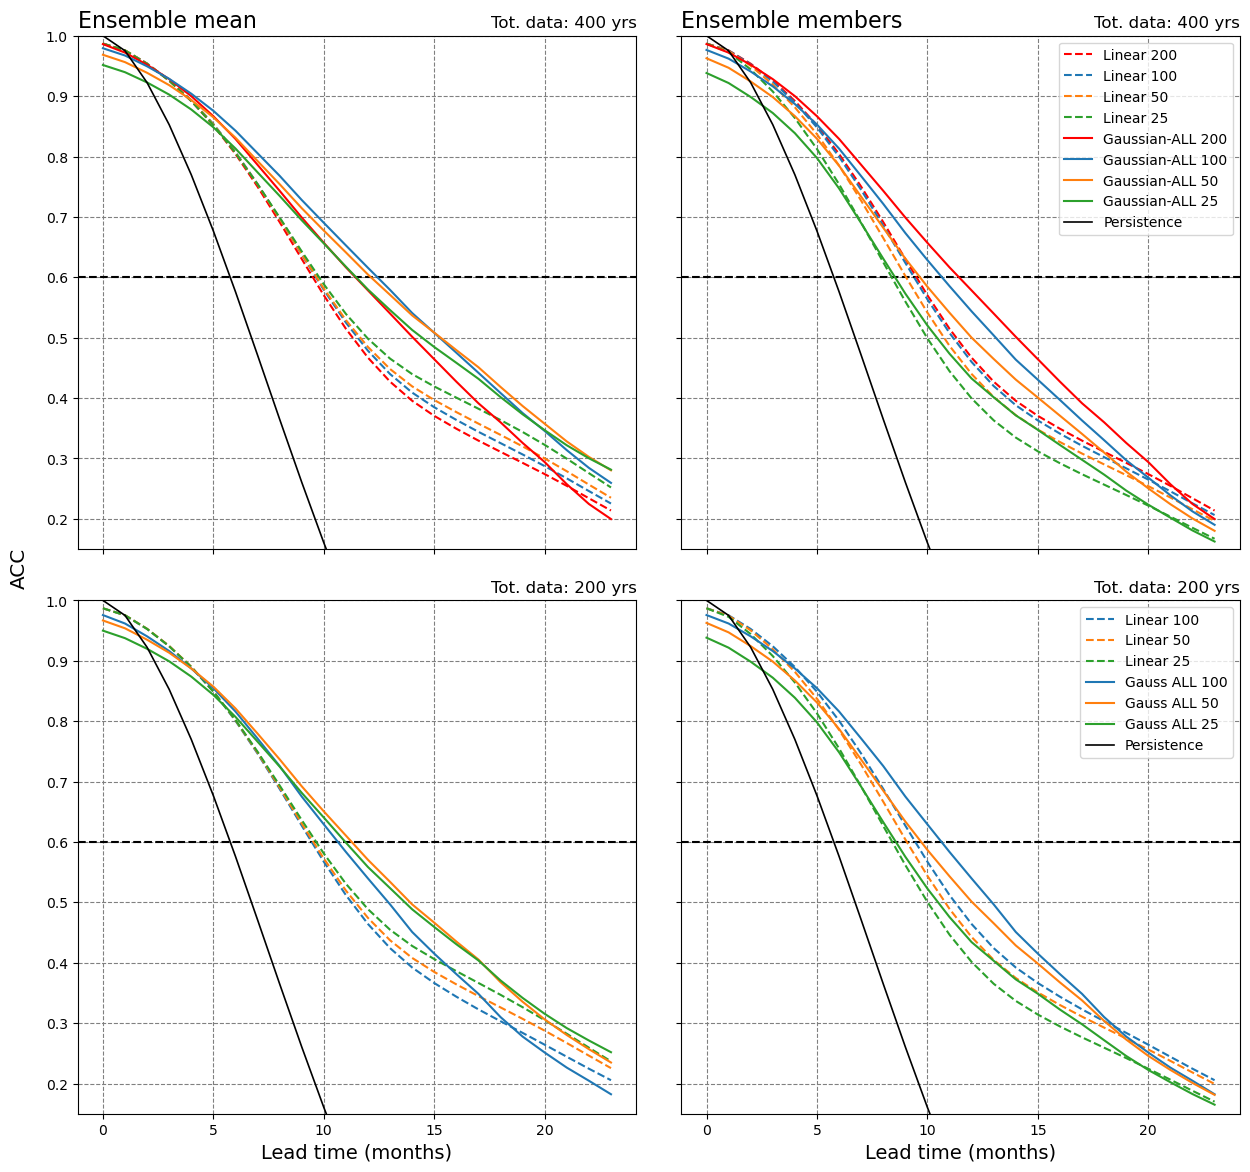

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,14),sharey=True,sharex=True)

xval=range(0,24)

##############################
###      400 MEAN         ### 
##############################

ax[0,0].axhline(0.6, linestyle='--',color='black')
#ax[0,0].set_xlabel('Time (months)')
#ax[0,0].set_ylabel('Anomaly Correlation')
ax[0,0].set_ylim([0.15,1])
ax[0,0].set_title('',loc='left')

ax[0,0].plot(xval, np.mean(Poly_mean_200_400, axis=1), lw=1.5, label='Linear 200', linestyle='dashed', c='red')
ax[0,0].plot(xval, np.mean(Poly_mean_100_400, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[0,0].plot(xval, np.mean(Poly_mean_50_400, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[0,0].plot(xval, np.mean(Poly_mean_25_400, axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[0,0].set_prop_cycle(None)
ax[0,0].plot(xval, np.mean(GaussALL_mean_200_400, axis=1), lw=1.5, label='Gauss ALL 200', c='red')
ax[0,0].plot(xval, np.mean(GaussALL_mean_100_400, axis=1), lw=1.5, label='Gauss ALL 100')
ax[0,0].plot(xval, np.mean(GaussALL_mean_50_400, axis=1), lw=1.5, label='Gauss ALL 50')
ax[0,0].plot(xval, np.mean(GaussALL_mean_25_400, axis=1), lw=1.5, label='Gauss ALL 25')

ax[0,0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[0,0].set_title('Ensemble mean',fontsize=16, loc='left')
ax[0,0].set_title('Tot. data: 400 yrs',fontsize=12, loc='right')
ax[0,0].yaxis.grid(color='gray', linestyle='dashed')
ax[0,0].xaxis.grid(color='gray', linestyle='dashed')


##############################
###      400 MEMB         ### 
##############################

ax[0,1].axhline(0.6, linestyle='--',color='black')
#ax[0,1].set_xlabel('Time (months)')
#ax[0,1].set_ylabel('Anomaly Correlation')
ax[0,1].set_ylim([0.15,1])
ax[0,1].set_title('',loc='left')

ax[0,1].plot(xval, np.mean(Poly_ind_200_400, axis=1), lw=1.5, label='Linear 200', linestyle='dashed', c='red')
ax[0,1].plot(xval, np.mean(np.mean(Poly_ind_100_400, axis=1),axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[0,1].plot(xval, np.mean(np.mean(Poly_ind_50_400, axis=1),axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[0,1].plot(xval, np.mean(np.mean(Poly_ind_25_400, axis=1),axis=1), lw=1.5, label='Linear 25', linestyle='dashed')

ax[0,1].set_prop_cycle(None)
ax[0,1].plot(xval, np.mean(GaussALL_ind_200_400, axis=1), lw=1.5, label='Gaussian-ALL 200', c='red')
ax[0,1].plot(xval, np.mean(np.mean(GaussALL_ind_100_400, axis=1),axis=1), lw=1.5, label='Gaussian-ALL 100')
ax[0,1].plot(xval, np.mean(np.mean(GaussALL_ind_50_400, axis=1),axis=1), lw=1.5, label='Gaussian-ALL 50')
ax[0,1].plot(xval, np.mean(np.mean(GaussALL_ind_25_400, axis=1),axis=1), lw=1.5, label='Gaussian-ALL 25')

ax[0,1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[0,1].set_title('Ensemble members',fontsize=16, loc='left')
ax[0,1].set_title('Tot. data: 400 yrs',fontsize=12, loc='right')
ax[0,1].yaxis.grid(color='gray', linestyle='dashed')
ax[0,1].xaxis.grid(color='gray', linestyle='dashed')
ax[0,1].legend(loc='upper right')


##############################
###      200 MEAN         ### 
##############################

ax[1,0].axhline(0.6, linestyle='--',color='black')
#ax[1,0].set_xlabel('Time (months)')
#ax[1,0].set_ylabel('Anomaly Correlation')
ax[1,0].set_ylim([0.15,1])
ax[1,0].set_title('',loc='left')

ax[1,0].plot(xval, np.mean(Poly_mean_100_200, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[1,0].plot(xval, np.mean(Poly_mean_50_200, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[1,0].plot(xval, np.mean(Poly_mean_25_200, axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[1,0].set_prop_cycle(None)
ax[1,0].plot(xval, np.mean(GaussALL_mean_100_200, axis=1), lw=1.5, label='Gauss ALL 100')
ax[1,0].plot(xval, np.mean(GaussALL_mean_50_200, axis=1), lw=1.5, label='Gauss ALL 50')
ax[1,0].plot(xval, np.mean(GaussALL_mean_25_200, axis=1), lw=1.5, label='Gauss ALL 25')
ax[1,0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[1,0].set_xlabel('Lead time (months)',fontsize=14)

ax[1,0].set_title('Tot. data: 200 yrs',fontsize=12, loc='right')
ax[1,0].yaxis.grid(color='gray', linestyle='dashed')
ax[1,0].xaxis.grid(color='gray', linestyle='dashed')


##############################
###      200 MEMB         ### 
##############################

ax[1,1].axhline(0.6, linestyle='--',color='black')
#ax[1,1].set_xlabel('Time (months)')
#ax[1,1].set_ylabel('Anomaly Correlation')
ax[1,1].set_ylim([0.15,1])
ax[1,1].set_title('',loc='left')

ax[1,1].plot(xval, np.mean(Poly_ind_100_200, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[1,1].plot(xval, np.mean(np.mean(Poly_ind_50_200, axis=1),axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[1,1].plot(xval, np.mean(np.mean(Poly_ind_25_200, axis=1),axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[1,1].set_prop_cycle(None)
ax[1,1].plot(xval, np.mean(GaussALL_ind_100_200, axis=1), lw=1.5, label='Gauss ALL 100')
ax[1,1].plot(xval, np.mean(np.mean(GaussALL_ind_50_200, axis=1),axis=1), lw=1.5, label='Gauss ALL 50')
ax[1,1].plot(xval, np.mean(np.mean(GaussALL_ind_25_200, axis=1),axis=1), lw=1.5, label='Gauss ALL 25')
ax[1,1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[1,1].set_title('Tot. data: 200 yrs',fontsize=12, loc='right')
ax[1,1].yaxis.grid(color='gray', linestyle='dashed')
ax[1,1].xaxis.grid(color='gray', linestyle='dashed')
ax[1,1].set_xlabel('Lead time (months)',fontsize=14)
ax[1,1].legend(loc='upper right')


fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')

plt.subplots_adjust(wspace=0.08, hspace=0.1)
plt.suptitle('',fontsize='xx-large')
plt.savefig('Fig 15.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 15.jpg', orientation='landscape',  format='jpg')

plt.show() 

# Fig 15 modified

In [5]:
Poly_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_100.npy')

Poly_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_100.npy')

In [6]:
Poly_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_50.npy')

Poly_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')

In [17]:
Poly_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_25.npy')

Poly_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25.npy')

In [9]:
Poly_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [10]:
Poly_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [11]:
Poly_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [12]:
Poly_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_25.npy')

Poly_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_25.npy')

In [16]:
GaussALL_mean_25_200.shape

(24, 10)

In [25]:
lead=12

#200
acc_gauss_mean_200=np.zeros(3)
acc_gauss_mean_200[0]=np.mean(GaussALL_mean_25_200[lead])
acc_gauss_mean_200[1]=np.mean(GaussALL_mean_50_200[lead])
acc_gauss_mean_200[2]=np.mean(GaussALL_mean_100_200[lead])

acc_gauss_ind_200=np.zeros(3)
acc_gauss_ind_200[0]=np.mean(GaussALL_ind_25_200[lead])
acc_gauss_ind_200[1]=np.mean(GaussALL_ind_50_200[lead])
acc_gauss_ind_200[2]=np.mean(GaussALL_ind_100_200[lead])

acc_poly_mean_200=np.zeros(3)
acc_poly_mean_200[0]=np.mean(Poly_mean_25_200[lead])
acc_poly_mean_200[1]=np.mean(Poly_mean_50_200[lead])
acc_poly_mean_200[2]=np.mean(Poly_mean_100_200[lead])

acc_poly_ind_200=np.zeros(3)
acc_poly_ind_200[0]=np.mean(Poly_ind_25_200[lead])
acc_poly_ind_200[1]=np.mean(Poly_ind_50_200[lead])
acc_poly_ind_200[2]=np.mean(Poly_ind_100_200[lead])

#400
acc_gauss_mean_400=np.zeros(4)
acc_gauss_mean_400[0]=np.mean(GaussALL_mean_25_400[lead])
acc_gauss_mean_400[1]=np.mean(GaussALL_mean_50_400[lead])
acc_gauss_mean_400[2]=np.mean(GaussALL_mean_100_400[lead])
acc_gauss_mean_400[3]=np.mean(GaussALL_mean_200_400[lead])

acc_gauss_ind_400=np.zeros(4)
acc_gauss_ind_400[0]=np.mean(GaussALL_ind_25_400[lead])
acc_gauss_ind_400[1]=np.mean(GaussALL_ind_50_400[lead])
acc_gauss_ind_400[2]=np.mean(GaussALL_ind_100_400[lead])
acc_gauss_ind_400[3]=np.mean(GaussALL_ind_200_400[lead])

acc_poly_mean_400=np.zeros(4)
acc_poly_mean_400[0]=np.mean(Poly_mean_25_400[lead])
acc_poly_mean_400[1]=np.mean(Poly_mean_50_400[lead])
acc_poly_mean_400[2]=np.mean(Poly_mean_100_400[lead])
acc_poly_mean_400[3]=np.mean(Poly_mean_200_400[lead])

acc_poly_ind_400=np.zeros(4)
acc_poly_ind_400[0]=np.mean(Poly_ind_25_400[lead])
acc_poly_ind_400[1]=np.mean(Poly_ind_50_400[lead])
acc_poly_ind_400[2]=np.mean(Poly_ind_100_400[lead])
acc_poly_ind_400[3]=np.mean(Poly_ind_200_400[lead])

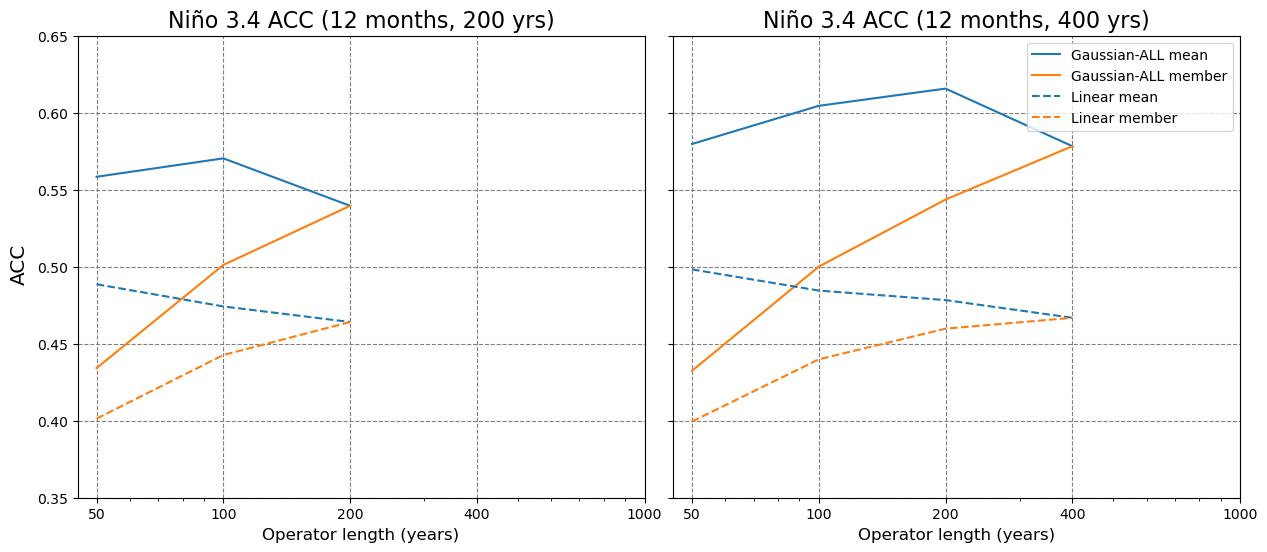

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=True, sharey=True)


##################################################################
#############              200              ######################
##################################################################

xval=[50,100,200,400,1000]
labels=['50','100','200','400','1000']

xval_200=[50,100,200]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax[0].set_xlabel('Operator length (years)',fontsize=12)
ax[0].set_ylim([0.4,0.7])
ax[0].set_title('',loc='left')

ax[0].plot(xval_200, acc_gauss_mean_200, lw=1.5, label='Gaussian-ALL mean')
ax[0].plot(xval_200, acc_gauss_ind_200, lw=1.5, label='Gaussian-ALL member')
ax[0].set_prop_cycle(None)
ax[0].plot(xval_200, acc_poly_mean_200, lw=1.5, label='Linear mean', linestyle='dashed')
ax[0].plot(xval_200, acc_poly_ind_200, lw=1.5, label='Linear member', linestyle='dashed')

bigtitle = f'Niño 3.4 ACC ({lead} months, 200 yrs)' 
ax[0].set_title(bigtitle,fontsize=16)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=labels)

##################################################################
#############              400              ######################
##################################################################

xval_400=[50,100,200,400]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax[1].set_xlabel('Operator length (years)',fontsize=12)
ax[1].set_ylim([0.35,0.65])
ax[1].set_title('',loc='left')

ax[1].plot(xval_400, acc_gauss_mean_400, lw=1.5, label='Gaussian-ALL mean')
ax[1].plot(xval_400, acc_gauss_ind_400, lw=1.5, label='Gaussian-ALL member')
ax[1].set_prop_cycle(None)
ax[1].plot(xval_400, acc_poly_mean_400, lw=1.5, label='Linear mean', linestyle='dashed')
ax[1].plot(xval_400, acc_poly_ind_400, lw=1.5, label='Linear member', linestyle='dashed')

bigtitle = f'Niño 3.4 ACC ({lead} months, 400 yrs)' 
ax[1].set_title(bigtitle,fontsize=16)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=labels)

plt.subplots_adjust(wspace=0.05)
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')

ax[1].legend(loc='upper right')

#plt.savefig('Fig 6.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 6.jpg', orientation='landscape',  format='jpg')
plt.show() 

# Fig 15 modified 2

In [9]:
Poly_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_1000.npy')
Gauss30_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_1000.npy')
GaussALL_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_1000.npy')

Poly_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_1000.npy')
Gauss30_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_1000.npy')
GaussALL_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_1000.npy')

In [10]:
Poly_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_400.npy')
Gauss30_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_400.npy')
GaussALL_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_400.npy')

Poly_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_400.npy')
Gauss30_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_400.npy')
GaussALL_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_400.npy')

In [11]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [12]:
Poly_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [13]:
Poly_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [14]:
Poly_mean_75_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_75.npy')
Gauss30_mean_75_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_75.npy')
GaussALL_mean_75_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_75.npy')

Poly_ind_75_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_75.npy')
Gauss30_ind_75_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_75.npy')
GaussALL_ind_75_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_75.npy')

In [15]:
Poly_mean_50_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSALL_50.npy')

Poly_ind_50_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')

In [16]:
Poly_mean_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_30.npy')
Gauss30_mean_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_30.npy')
GaussALL_mean_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_30.npy')

Poly_ind_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_30.npy')
Gauss30_ind_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_30.npy')
GaussALL_ind_30_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_30.npy')

In [17]:
Poly_mean_25_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_25.npy')

Poly_ind_25_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25.npy')

In [18]:
Poly_mean_15_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_POLY_15.npy')
#Gauss30_mean_15_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSS30_15.npy')
GaussALL_mean_15_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEAN_CORR_GAUSSALL_15.npy')

Poly_ind_15_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_POLY_15.npy')
#Gauss30_ind_15_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSS30_15.npy')
GaussALL_ind_15_150=np.load('150 years testing/150 years testing-Evaluation metrics/150y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_15.npy')

In [19]:
Poly_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_100.npy')

Poly_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_100.npy')

In [20]:
Poly_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_50.npy')

Poly_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_50.npy')

In [21]:
Poly_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEAN_CORR_GAUSALL_25.npy')

Poly_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_200=np.load('200 years testing/200 years testing-Evaluation metrics/200y_ENSEMBLE_MEMBERS_CORR_GAUSALL_25.npy')

In [22]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [23]:
Poly_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [24]:
Poly_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [25]:
Poly_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [26]:
Poly_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_POLY_25.npy')
Gauss30_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSS30_25.npy')
GaussALL_mean_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEAN_CORR_GAUSSALL_25.npy')

Poly_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_POLY_25.npy')
Gauss30_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSS30_25.npy')
GaussALL_ind_25_400=np.load('400 years testing/400 years testing-Evaluation metrics/400y_ENSEMBLE_MEMBERS_CORR_GAUSSALL_25.npy')

In [27]:
Poly_mean_400.shape

(24,)

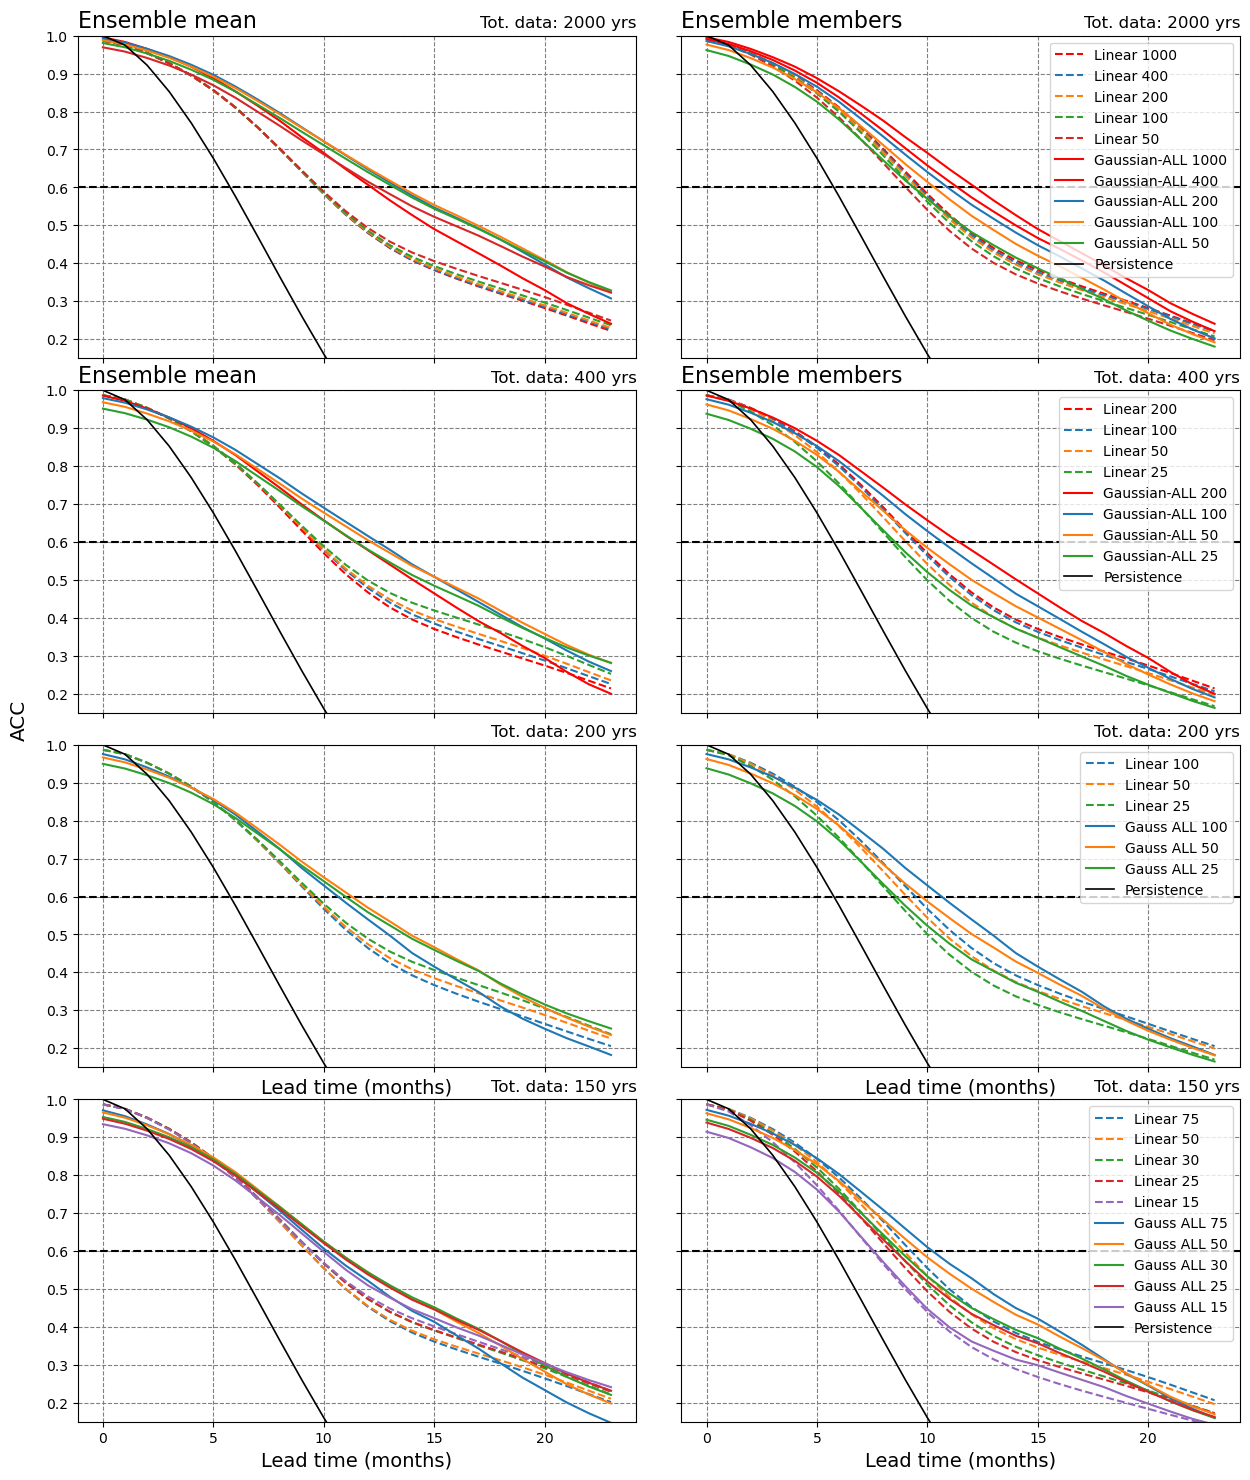

In [28]:
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,18),sharey=True,sharex=True)

xval=range(0,24)

##############################
###      2000 MEAN         ### 
##############################

ax[0,0].axhline(0.6, linestyle='--',color='black')
ax[0,0].set_ylim([0.15,1])
ax[0,0].set_title('',loc='left')

ax[0,0].plot(xval, Poly_mean_1000, lw=1.5, label='Linear 1000', linestyle='dashed', c='red')
ax[0,0].plot(xval, Poly_mean_400, lw=1.5, label='Linear 400', linestyle='dashed')
ax[0,0].plot(xval, Poly_mean_200, lw=1.5, label='Linear 200', linestyle='dashed')
ax[0,0].plot(xval, Poly_mean_100, lw=1.5, label='Linear 100', linestyle='dashed')
ax[0,0].plot(xval, Poly_mean_50, lw=1.5, label='Linear 50', linestyle='dashed')
ax[0,0].set_prop_cycle(None)
ax[0,0].plot(xval, GaussALL_mean_1000, lw=1.5, label='Gauss ALL 1000', c='red')
ax[0,0].plot(xval, GaussALL_mean_400, lw=1.5, label='Gauss ALL 400')
ax[0,0].plot(xval, GaussALL_mean_200, lw=1.5, label='Gauss ALL 200')
ax[0,0].plot(xval, GaussALL_mean_100, lw=1.5, label='Gauss ALL 100')
ax[0,0].plot(xval, GaussALL_mean_50, lw=1.5, label='Gauss ALL 50')

ax[0,0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[0,0].set_title('Ensemble mean',fontsize=16, loc='left')
ax[0,0].set_title('Tot. data: 2000 yrs',fontsize=12, loc='right')
ax[0,0].yaxis.grid(color='gray', linestyle='dashed')
ax[0,0].xaxis.grid(color='gray', linestyle='dashed')


##############################
###      2000 MEMB         ### 
##############################

ax[0,1].axhline(0.6, linestyle='--',color='black')
ax[0,1].set_ylim([0.15,1])
ax[0,1].set_title('',loc='left')

ax[0,1].plot(xval, np.mean(Poly_ind_1000, axis=1), lw=1.5, label='Linear 1000', linestyle='dashed', c='red')
ax[0,1].plot(xval, np.mean(Poly_ind_400, axis=1), lw=1.5, label='Linear 400', linestyle='dashed')
ax[0,1].plot(xval, np.mean(Poly_ind_200, axis=1), lw=1.5, label='Linear 200', linestyle='dashed')
ax[0,1].plot(xval, np.mean(Poly_ind_100, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[0,1].plot(xval, np.mean(Poly_ind_50, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')

ax[0,1].set_prop_cycle(None)
ax[0,1].plot(xval, np.mean(GaussALL_ind_1000, axis=1), lw=1.5, label='Gaussian-ALL 1000', c='red')
ax[0,1].plot(xval, np.mean(GaussALL_ind_400, axis=1), lw=1.5, label='Gaussian-ALL 400', c='red')
ax[0,1].plot(xval, np.mean(GaussALL_ind_200, axis=1), lw=1.5, label='Gaussian-ALL 200')
ax[0,1].plot(xval, np.mean(GaussALL_ind_100, axis=1), lw=1.5, label='Gaussian-ALL 100')
ax[0,1].plot(xval, np.mean(GaussALL_ind_50, axis=1), lw=1.5, label='Gaussian-ALL 50')

ax[0,1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[0,1].set_title('Ensemble members',fontsize=16, loc='left')
ax[0,1].set_title('Tot. data: 2000 yrs',fontsize=12, loc='right')
ax[0,1].yaxis.grid(color='gray', linestyle='dashed')
ax[0,1].xaxis.grid(color='gray', linestyle='dashed')
ax[0,1].legend(loc='upper right')


##############################
###      400 MEAN         ### 
##############################

ax[1,0].axhline(0.6, linestyle='--',color='black')
ax[1,0].set_ylim([0.15,1])
ax[1,0].set_title('',loc='left')

ax[1,0].plot(xval, np.mean(Poly_mean_200_400, axis=1), lw=1.5, label='Linear 200', linestyle='dashed', c='red')
ax[1,0].plot(xval, np.mean(Poly_mean_100_400, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[1,0].plot(xval, np.mean(Poly_mean_50_400, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[1,0].plot(xval, np.mean(Poly_mean_25_400, axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[1,0].set_prop_cycle(None)
ax[1,0].plot(xval, np.mean(GaussALL_mean_200_400, axis=1), lw=1.5, label='Gauss ALL 200', c='red')
ax[1,0].plot(xval, np.mean(GaussALL_mean_100_400, axis=1), lw=1.5, label='Gauss ALL 100')
ax[1,0].plot(xval, np.mean(GaussALL_mean_50_400, axis=1), lw=1.5, label='Gauss ALL 50')
ax[1,0].plot(xval, np.mean(GaussALL_mean_25_400, axis=1), lw=1.5, label='Gauss ALL 25')

ax[1,0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[1,0].set_title('Ensemble mean',fontsize=16, loc='left')
ax[1,0].set_title('Tot. data: 400 yrs',fontsize=12, loc='right')
ax[1,0].yaxis.grid(color='gray', linestyle='dashed')
ax[1,0].xaxis.grid(color='gray', linestyle='dashed')


##############################
###      400 MEMB         ### 
##############################

ax[1,1].axhline(0.6, linestyle='--',color='black')
ax[1,1].set_ylim([0.15,1])
ax[1,1].set_title('',loc='left')

ax[1,1].plot(xval, np.mean(Poly_ind_200_400, axis=1), lw=1.5, label='Linear 200', linestyle='dashed', c='red')
ax[1,1].plot(xval, np.mean(np.mean(Poly_ind_100_400, axis=1),axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[1,1].plot(xval, np.mean(np.mean(Poly_ind_50_400, axis=1),axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[1,1].plot(xval, np.mean(np.mean(Poly_ind_25_400, axis=1),axis=1), lw=1.5, label='Linear 25', linestyle='dashed')

ax[1,1].set_prop_cycle(None)
ax[1,1].plot(xval, np.mean(GaussALL_ind_200_400, axis=1), lw=1.5, label='Gaussian-ALL 200', c='red')
ax[1,1].plot(xval, np.mean(np.mean(GaussALL_ind_100_400, axis=1),axis=1), lw=1.5, label='Gaussian-ALL 100')
ax[1,1].plot(xval, np.mean(np.mean(GaussALL_ind_50_400, axis=1),axis=1), lw=1.5, label='Gaussian-ALL 50')
ax[1,1].plot(xval, np.mean(np.mean(GaussALL_ind_25_400, axis=1),axis=1), lw=1.5, label='Gaussian-ALL 25')

ax[1,1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[1,1].set_title('Ensemble members',fontsize=16, loc='left')
ax[1,1].set_title('Tot. data: 400 yrs',fontsize=12, loc='right')
ax[1,1].yaxis.grid(color='gray', linestyle='dashed')
ax[1,1].xaxis.grid(color='gray', linestyle='dashed')
ax[1,1].legend(loc='upper right')


##############################
###      200 MEAN         ### 
##############################

ax[2,0].axhline(0.6, linestyle='--',color='black')
ax[2,0].set_ylim([0.15,1])
ax[2,0].set_title('',loc='left')

ax[2,0].plot(xval, np.mean(Poly_mean_100_200, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[2,0].plot(xval, np.mean(Poly_mean_50_200, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[2,0].plot(xval, np.mean(Poly_mean_25_200, axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[2,0].set_prop_cycle(None)
ax[2,0].plot(xval, np.mean(GaussALL_mean_100_200, axis=1), lw=1.5, label='Gauss ALL 100')
ax[2,0].plot(xval, np.mean(GaussALL_mean_50_200, axis=1), lw=1.5, label='Gauss ALL 50')
ax[2,0].plot(xval, np.mean(GaussALL_mean_25_200, axis=1), lw=1.5, label='Gauss ALL 25')
ax[2,0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[2,0].set_xlabel('Lead time (months)',fontsize=14)

ax[2,0].set_title('Tot. data: 200 yrs',fontsize=12, loc='right')
ax[2,0].yaxis.grid(color='gray', linestyle='dashed')
ax[2,0].xaxis.grid(color='gray', linestyle='dashed')


##############################
###      200 MEMB         ### 
##############################

ax[2,1].axhline(0.6, linestyle='--',color='black')
ax[2,1].set_ylim([0.15,1])
ax[2,1].set_title('',loc='left')

ax[2,1].plot(xval, np.mean(Poly_ind_100_200, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[2,1].plot(xval, np.mean(np.mean(Poly_ind_50_200, axis=1),axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[2,1].plot(xval, np.mean(np.mean(Poly_ind_25_200, axis=1),axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[2,1].set_prop_cycle(None)
ax[2,1].plot(xval, np.mean(GaussALL_ind_100_200, axis=1), lw=1.5, label='Gauss ALL 100')
ax[2,1].plot(xval, np.mean(np.mean(GaussALL_ind_50_200, axis=1),axis=1), lw=1.5, label='Gauss ALL 50')
ax[2,1].plot(xval, np.mean(np.mean(GaussALL_ind_25_200, axis=1),axis=1), lw=1.5, label='Gauss ALL 25')
ax[2,1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[2,1].set_title('Tot. data: 200 yrs',fontsize=12, loc='right')
ax[2,1].yaxis.grid(color='gray', linestyle='dashed')
ax[2,1].xaxis.grid(color='gray', linestyle='dashed')
ax[2,1].set_xlabel('Lead time (months)',fontsize=14)
ax[2,1].legend(loc='upper right')

##############################
###      150 MEAN         ### 
##############################

ax[3,0].axhline(0.6, linestyle='--',color='black')
ax[3,0].set_ylim([0.15,1])
ax[3,0].set_title('',loc='left')

ax[3,0].plot(xval, np.mean(Poly_mean_75_150, axis=1), lw=1.5, label='Linear 75', linestyle='dashed')
ax[3,0].plot(xval, np.mean(Poly_mean_50_150, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[3,0].plot(xval, np.mean(Poly_mean_30_150, axis=1), lw=1.5, label='Linear 30', linestyle='dashed')
ax[3,0].plot(xval, np.mean(Poly_mean_25_150, axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[3,0].plot(xval, np.mean(Poly_mean_15_150, axis=1), lw=1.5, label='Linear 15', linestyle='dashed')

ax[3,0].set_prop_cycle(None)
ax[3,0].plot(xval, np.mean(GaussALL_mean_75_150, axis=1), lw=1.5, label='Gauss ALL 75')
ax[3,0].plot(xval, np.mean(GaussALL_mean_50_150, axis=1), lw=1.5, label='Gauss ALL 50')
ax[3,0].plot(xval, np.mean(GaussALL_mean_30_150, axis=1), lw=1.5, label='Gauss ALL 30')
ax[3,0].plot(xval, np.mean(GaussALL_mean_25_150, axis=1), lw=1.5, label='Gauss ALL 25')
ax[3,0].plot(xval, np.mean(GaussALL_mean_15_150, axis=1), lw=1.5, label='Gauss ALL 15')

ax[3,0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
ax[3,0].set_xlabel('Lead time (months)',fontsize=14)

ax[3,0].set_title('Tot. data: 150 yrs',fontsize=12, loc='right')
ax[3,0].yaxis.grid(color='gray', linestyle='dashed')
ax[3,0].xaxis.grid(color='gray', linestyle='dashed')


##############################
###      150 MEMB         ### 
##############################

ax[3,1].axhline(0.6, linestyle='--',color='black')
ax[3,1].set_ylim([0.15,1])
ax[3,1].set_title('',loc='left')

ax[3,1].plot(xval, np.mean(np.mean(Poly_ind_75_150, axis=1),axis=1), lw=1.5, label='Linear 75', linestyle='dashed')
ax[3,1].plot(xval, np.mean(np.mean(Poly_ind_50_150, axis=1),axis=1), lw=1.5, label='Linear 50', linestyle='dashed')
ax[3,1].plot(xval, np.mean(np.mean(Poly_ind_30_150, axis=1),axis=1), lw=1.5, label='Linear 30', linestyle='dashed')
ax[3,1].plot(xval, np.mean(np.mean(Poly_ind_25_150, axis=1),axis=1), lw=1.5, label='Linear 25', linestyle='dashed')
ax[3,1].plot(xval, np.mean(np.mean(Poly_ind_15_150, axis=1),axis=1), lw=1.5, label='Linear 15', linestyle='dashed')

ax[3,1].set_prop_cycle(None)
ax[3,1].plot(xval, np.mean(np.mean(GaussALL_ind_75_150, axis=1),axis=1), lw=1.5, label='Gauss ALL 75')
ax[3,1].plot(xval, np.mean(np.mean(GaussALL_ind_50_150, axis=1),axis=1), lw=1.5, label='Gauss ALL 50')
ax[3,1].plot(xval, np.mean(np.mean(GaussALL_ind_30_150, axis=1),axis=1), lw=1.5, label='Gauss ALL 30')
ax[3,1].plot(xval, np.mean(np.mean(GaussALL_ind_25_150, axis=1),axis=1), lw=1.5, label='Gauss ALL 25')
ax[3,1].plot(xval, np.mean(np.mean(GaussALL_ind_15_150, axis=1),axis=1), lw=1.5, label='Gauss ALL 15')

ax[3,1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[3,1].set_title('Tot. data: 150 yrs',fontsize=12, loc='right')
ax[3,1].yaxis.grid(color='gray', linestyle='dashed')
ax[3,1].xaxis.grid(color='gray', linestyle='dashed')
ax[3,1].set_xlabel('Lead time (months)',fontsize=14)
ax[3,1].legend(loc='upper right')


fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')

plt.subplots_adjust(wspace=0.08, hspace=0.1)
plt.suptitle('',fontsize='xx-large')
plt.savefig('Fig 15.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 15.jpg', orientation='landscape',  format='jpg')

plt.show() 

<Figure size 640x480 with 0 Axes>

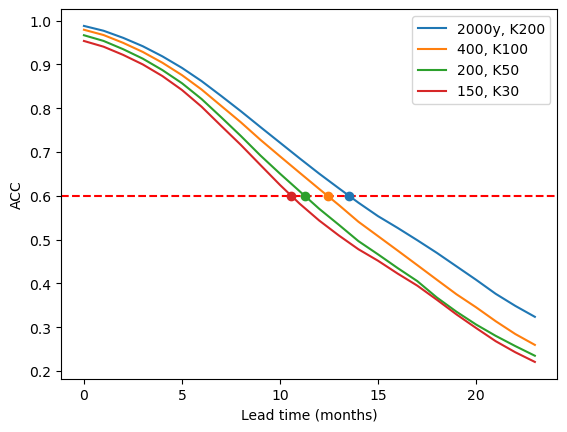

Intersections for Array 1:
  x = 13.52485133465258, y = 0.6

Intersections for Array 2:
  x = 12.428304057298451, y = 0.6

Intersections for Array 3:
  x = 11.262716382114233, y = 0.6

Intersections for Array 4:
  x = 10.581293671417738, y = 0.6



In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for multiple arrays
arrays = [
    (xval,GaussALL_mean_200 ),
    (xval, np.mean(GaussALL_mean_100_400, axis=1)),
    (xval, np.mean(GaussALL_mean_50_200, axis=1)),
    (xval, np.mean(GaussALL_mean_30_150, axis=1))
]

labels = [
    '2000y, K200',
    '400, K100',
    '200, K50',
    '150, K30'
]

# Horizontal line
y_horiz = 0.6  # y-value of the horizontal line

plt.figure()

# List to store all intersection points
all_intersections = []

plt.figure()

for i, (x, y) in enumerate(arrays):
    # Find where the array crosses the horizontal line
    differences = y - y_horiz
    sign_changes = np.where(np.diff(np.sign(differences)))[0]

    crossings_x = []
    crossings_y = []
    intersections = []  # To store intersections for this array

    for index in sign_changes:
        x1, x2 = x[index], x[index + 1]
        y1, y2 = y[index], y[index + 1]

        # Linear interpolation to find the exact crossing point
        x_cross = x1 + (y_horiz - y1) * (x2 - x1) / (y2 - y1)
        crossings_x.append(x_cross)
        crossings_y.append(y_horiz)
        intersections.append((x_cross, y_horiz))

    # Store intersections for this array
    all_intersections.append(intersections)

    # Plot the array
    plt.plot(x, y, label=labels[i])

    # Plot the intersections
    plt.scatter(crossings_x, crossings_y, zorder=5)

# Plot the horizontal line
plt.axhline(y=y_horiz, color='r', linestyle='--')

plt.xlabel('Lead time (months)')
plt.ylabel('ACC')
plt.legend()
plt.show()

# Print the intersection points
for i, intersections in enumerate(all_intersections):
    print(f"Intersections for Array {i+1}:")
    for x_cross, y_cross in intersections:
        print(f"  x = {x_cross}, y = {y_cross}")
    print()